### Code block 1: Package initialization
Import required packages, do not change.

In [142]:
import argparse
import os, sys
import time
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.utils import _single, _pair, _triple


### Code block 2: Useful classes
Customized implementation of [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), do not change.

In [143]:
class CONV(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=False, padding_mode='zeros'):
        self.input = None
        self.output = None
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(CONV, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation, 
            groups, bias, padding_mode)
    
    def forward(self, input):
        self.input = input
        # 'pytorch 2.0'
        self.output = super().forward(input)
        return self.output
    
class FC(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        self.input = None
        self.output = None
        super(FC, self).__init__(in_features, out_features, bias)
    
    def forward(self, input):
        self.input = input
        self.output = F.linear(input, self.weight, self.bias)
        return self.output

## Lab 2

### Code block 3: SimpleNN implementation

Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**

In [144]:
""" 
Lab 2(a)
Build the SimpleNN model by following Table 1
"""

# Create the neural network module: LeNet-5
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Layer definition
        self.conv1 = CONV(in_channels=3, out_channels=16, kernel_size=5, stride=1,
                             padding=2, dilation=1, groups=1,
                             bias=False, padding_mode='zeros')
        self.conv2 = CONV(in_channels=16, out_channels=16, kernel_size=3, stride=1,
                             padding=2, dilation=1, groups=1,
                             bias=False, padding_mode='zeros')
        self.conv3 = CONV(in_channels=16, out_channels=32, kernel_size=7, stride=1,
                             padding=2, dilation=1, groups=1,
                             bias=False, padding_mode='zeros')
        self.fc1   = FC(in_features=288, out_features=32, bias=True)
        self.fc2   = FC(in_features=32, out_features=10, bias=True)

    def forward(self, x):
        #print(x.size())
        # Forward pass computation
        # Conv 1
        out = F.relu(self.conv1(x))#; print(out.size())
        # MaxPool
        out = F.max_pool2d(out, 4, stride=2)#; print(out.size())
        # Conv 2
        out = F.relu(self.conv2(out)); print(out.size())
        # MaxPool
        out = F.max_pool2d(out, 3, stride=2)#; print(out.size())
        # Conv 3
        out = F.relu(self.conv3(out)); print(out.size())
        # MaxPool
        out = F.max_pool2d(out, 2, stride=2)#; print(out.size())
        # Flatten
        out = out.view(out.size(0), -1)#; print(out.size())
        # FC 1
        out = F.relu(self.fc1(out))#; print(out.size())
        # FC 2
        out = F.relu(self.fc2(out))#; print(out.size())
        return out

# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
net = SimpleNN()
net = net.to(device)

# Test forward pass
data = torch.randn(5,3,32,32)
data = data.to(device)
# Forward pass "data" through "net" to get output "out" 
out = net.forward(data)   #Your code here

# Check output shape
assert(out.detach().cpu().numpy().shape == (5,10))
print("Forward pass successful")

Run on CPU...
torch.Size([5, 16, 17, 17])
torch.Size([5, 32, 6, 6])
Forward pass successful


### Code block 4: Shape observation
Please follow the instructions in Lab 2(a) and fill in the code in the lines marked **Your code here**. Gather the printed results in Table 2 in your report.

In [145]:
"""
Lab 2(b)
"""
# Forward pass of a single image
data = torch.randn(1,3,32,32).to(device)
# Forward pass "data" through "net" to get output "out" 
out = net.forward(data)    #Your code here

# Iterate through all the CONV and FC layers of the model
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the input feature map of the module as a NumPy array
        input = module.input.detach().cpu().numpy()     #Your code here
        # Get the output feature map of the module as a NumPy array
        output = module.output.detach().cpu().numpy()     #Your code here
        # Get the weight of the module as a NumPy array
        weight = module.weight.detach().cpu().numpy()    #Your code here
        # Compute the number of parameters in the weight
        num_Param = np.prod([i for i in weight.shape])    #Your code here
        # Compute the number of MACs in the layer
        if isinstance(module, CONV):
            num_MAC = input.shape[1] * (np.array(module.kernel_size[0]) ** 2) * \
                      np.prod(output.shape)   #Your code here
            # C1 * K*k * C2 * H2 * W2
        else:  # isinstance(module, FC)
            num_MAC = len(input.flatten()) * len(output.flatten())   #Your code here
        
        print(f'{name:10} {str(input.shape):20} {str(output.shape):20} {str(weight.shape):20} {str(num_Param):10} {str(num_MAC):10}')


torch.Size([1, 16, 17, 17])
torch.Size([1, 32, 6, 6])
conv1      (1, 3, 32, 32)       (1, 16, 32, 32)      (16, 3, 5, 5)        1200       1228800   
conv2      (1, 16, 15, 15)      (1, 16, 17, 17)      (16, 16, 3, 3)       2304       665856    
conv3      (1, 16, 8, 8)        (1, 32, 6, 6)        (32, 16, 7, 7)       25088      903168    
fc1        (1, 288)             (1, 32)              (32, 288)            9216       9216      
fc2        (1, 32)              (1, 10)              (10, 32)             320        320       


## Lab 3 (Bonus)

### Code block 5: Initial weight histogram
Please follow the instructions in Lab 3(a) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

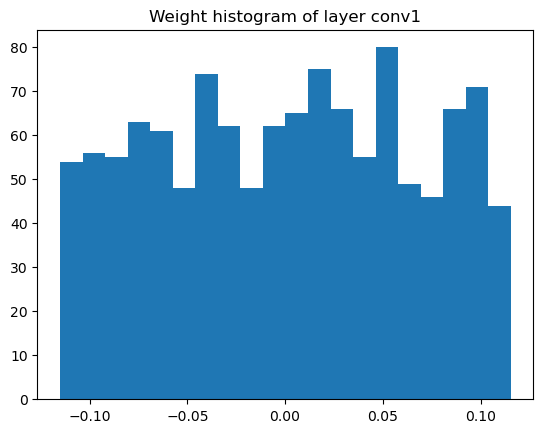

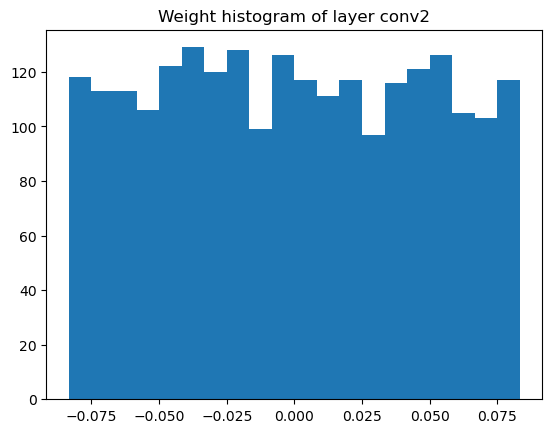

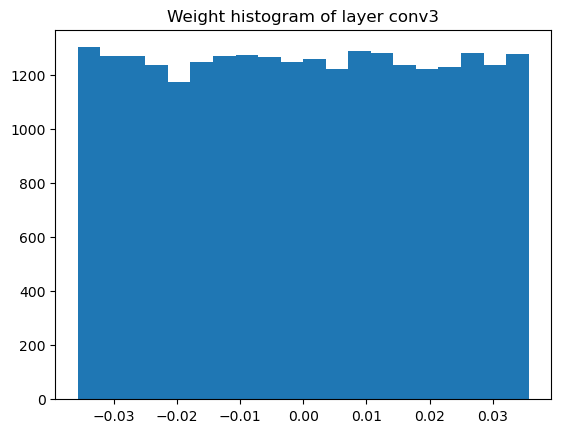

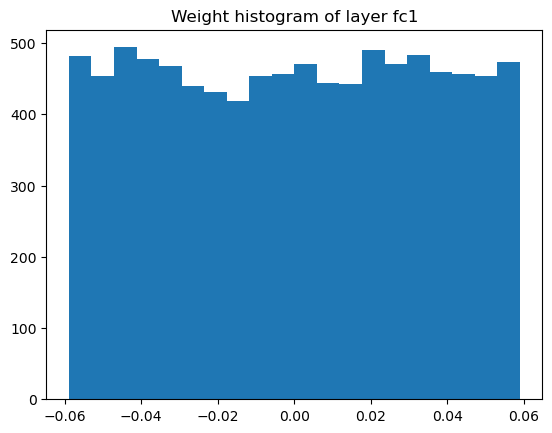

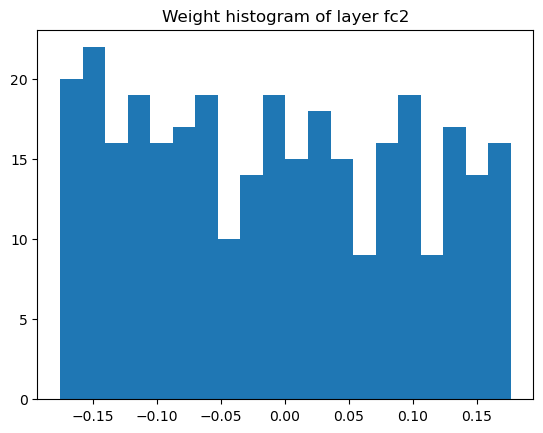

In [146]:
"""
Lab 3(a)
"""
# # my addition:
# size_title = 10
# size_label = 8
# size_ticks = 7
#
# fig, ax = plt.subplots(2, 3, dpi=300)
# ax_new = ax.flatten()
# plot_idx = 0
# ax_new[-1].axis('off')
# # end of my addition


for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the weight of the module as a NumPy array
        weight = module.weight.detach().cpu().numpy()     #Your code here
        
        # Reshape for histogram
        weight = weight.reshape(-1)
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.show()

#         # my addition:
#         weight = weight.reshape(-1)
#         ax_new[plot_idx].hist(weight, bins=20)
#         ax_new[plot_idx].set_title("Weight histogram\nof layer "+name, fontsize=size_title)
#         ax_new[plot_idx].set_xlabel("Value", fontsize=size_label)
#         ax_new[plot_idx].set_ylabel("Frequency", fontsize=size_label)
#         ax_new[plot_idx].tick_params(axis='x', which='both', labelsize=size_ticks)
#         ax_new[plot_idx].tick_params(axis='y', which='both', labelsize=size_ticks)
#         plot_idx += 1
# fig.tight_layout()
# plt.savefig('lab3a.pdf', dpi=700, bbox_inches='tight')
# end of my addition

### Code block 6: Gradient histogram
Please follow the instructions in Lab 3(b) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

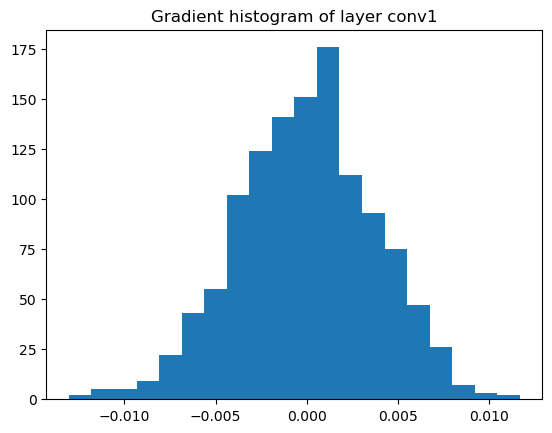

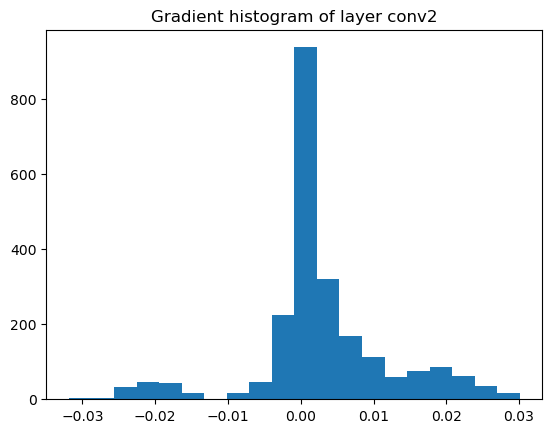

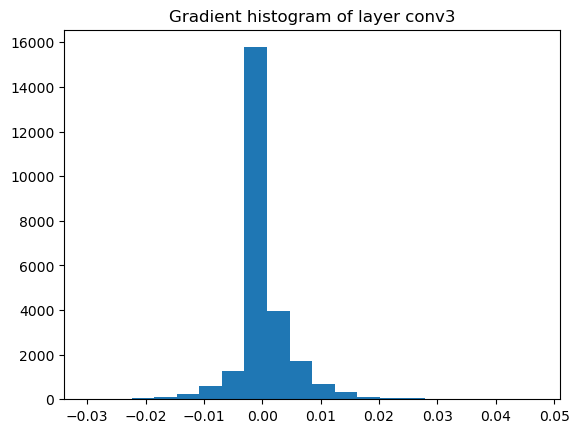

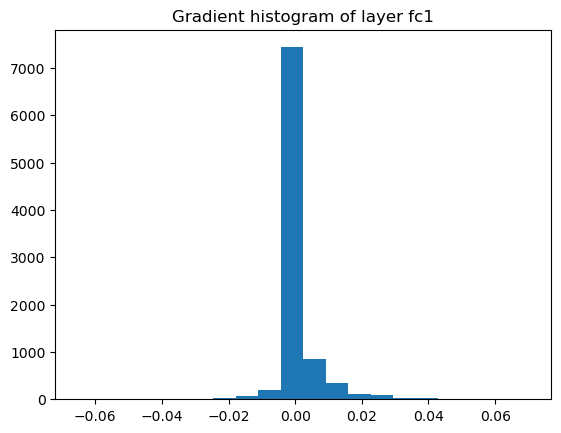

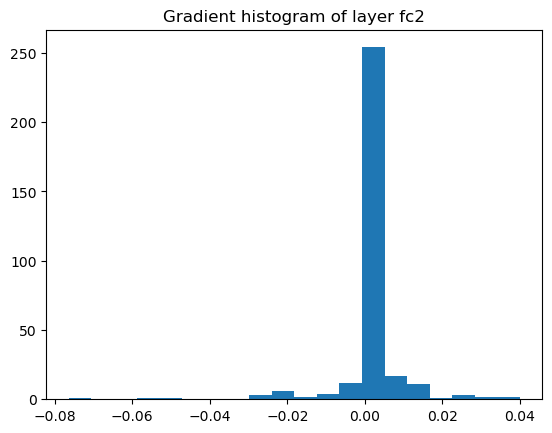

In [147]:
'''
Lab 3(b)
'''
# Loss definition
criterion = nn.MSELoss()
# Random target
target = torch.randn(1, 10).to(device)

# Loss computation, using out defined in Lab 2(b)
loss = criterion(out, target)    #Your code here
# Backward pass for gradients
     #Your code here
loss.backward()

# # my addition:
# fig, ax = plt.subplots(2, 3, dpi=300)
# ax_new = ax.flatten()
# plot_idx = 0
# ax_new[-1].axis('off')
# # end of my addition

for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        gradient = module.weight.grad.detach().cpu().numpy()     #Your code here

        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()

#         # my addition:
#         gradient = gradient.reshape(-1)
#         ax_new[plot_idx].hist(gradient, bins=20)
#         ax_new[plot_idx].set_title("Gradient histogram\nof layer "+name, fontsize=size_title)
#         ax_new[plot_idx].set_xlabel("Value", fontsize=size_label)
#         ax_new[plot_idx].set_ylabel("Frequency", fontsize=size_label)
#         ax_new[plot_idx].tick_params(axis='x', which='both', labelsize=size_ticks)
#         ax_new[plot_idx].tick_params(axis='y', which='both', labelsize=size_ticks)
#         plot_idx += 1
# fig.tight_layout()
# plt.savefig('lab3b.pdf', dpi=700, bbox_inches='tight')
# end of my addition

### Code block 7: Zero initialization?
Please follow the instructions in Lab 3(c) and fill in the code in the lines marked **Your code here**. Copy the output figures into your report.

torch.Size([1, 16, 17, 17])
torch.Size([1, 32, 6, 6])


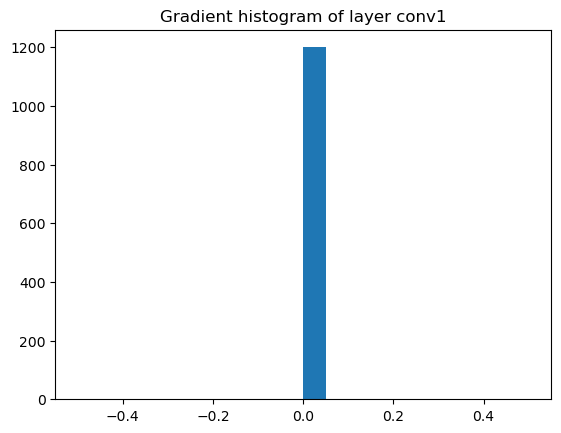

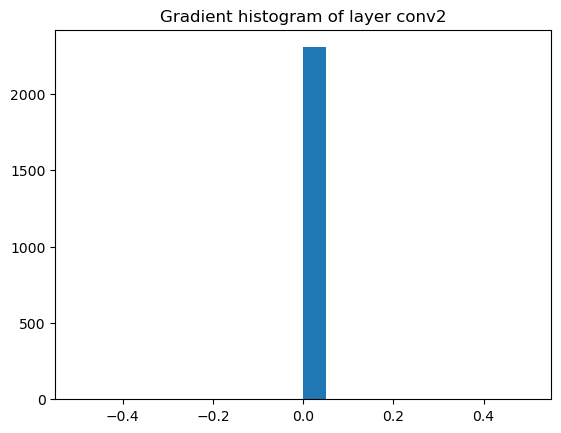

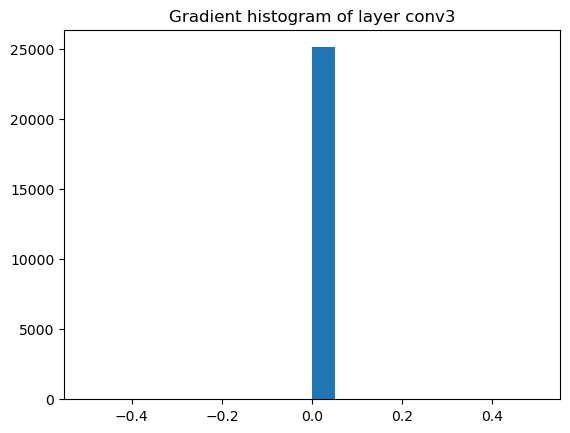

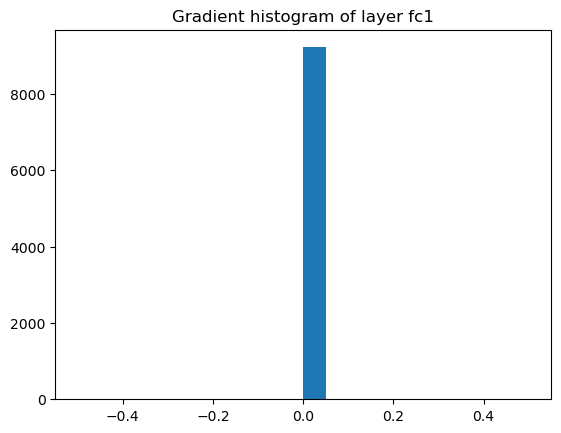

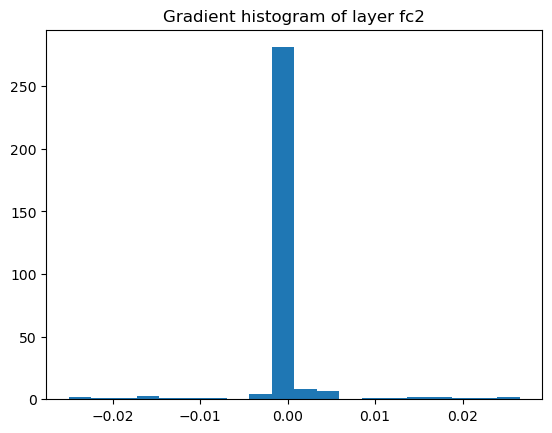

In [148]:
'''
Lab 3(c)
'''
# Set model weights to zero
for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Set the weight of each module to all zero
        module.weight.data.fill_(0)

# Reset gradients
net.zero_grad()
        
# Forward and backward pass
# Random data and target
data = torch.randn(1,3,32,32).to(device)
target = torch.randn(1, 10).to(device)

# Forward pass
out = net.forward(data)     #Your code here
# Loss computation
loss = criterion(out, target)     #Your code here
# Backward pass
loss.backward()     #Your code here

# # my addition:
# fig, ax = plt.subplots(2, 3, dpi=300)
# ax_new = ax.flatten()
# plot_idx = 0
# ax_new[-1].axis('off')
# # end of my addition


for name, module in net.named_modules():
    if isinstance(module, CONV) or isinstance(module, FC):
        # Get the gradient of the module as a NumPy array
        gradient = module.weight.grad.detach().cpu().numpy()     #Your code here
        
        # Reshape for histogram
        gradient = gradient.reshape(-1)
        _ = plt.hist(gradient, bins=20)
        plt.title("Gradient histogram of layer "+name)
        plt.show()

#         # my addition:
#         print(sum(np.abs(gradient).flatten()))
#         ax_new[plot_idx].hist(gradient, bins=20)
#         ax_new[plot_idx].set_title("Gradient histogram\nof layer "+name, fontsize=size_title)
#         ax_new[plot_idx].set_xlabel("Value", fontsize=size_label)
#         ax_new[plot_idx].set_ylabel("Frequency", fontsize=size_label)
#         ax_new[plot_idx].tick_params(axis='x', which='both', labelsize=size_ticks)
#         ax_new[plot_idx].tick_params(axis='y', which='both', labelsize=size_ticks)
#         plot_idx += 1
# fig.tight_layout()
# plt.savefig('lab3c.pdf', dpi=700, bbox_inches='tight')
# # end of my addition

The weights for all the convolution layers and the first FC layer are zero compared to lab 3b), which are approximately centred at zero but not identically zero. When using ReLU activation, the gradient with respect to the weights tensor is zero if every input to the ReLU module is zero. When the initial weights tensor is zero, the convolution of the input feature map with the weights tensor is also zero when the bias is zero. Since the identically-zero result of the convolution is fed into the ReLU function, the output of the ReLU function will also be zero. When using the chain rule to compute the derivative of loss with respect to the weights tensor, one of the intermediate gradients that appear is the gradient of the ReLU function with respect to its input, which becomes identically zero if the inputs to the ReLU function are all zero. Multiplication by a zero tensor causes the entire gradient to be zero as well. We didn't initialise the weights vector in lab 3b) as identically zero, so the model doesn't have gradients that are identically zero for the convolutional layers.